In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId

threshold = 0.6

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.05,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : 0,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'streamline',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.0001,
    'batch_size'    : 1000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_1024_512_256_128_00001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_0_0_streamline_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_0_normalized_08_05_005


0.772182546842127
0.7502186072205514
0.7373104168592349


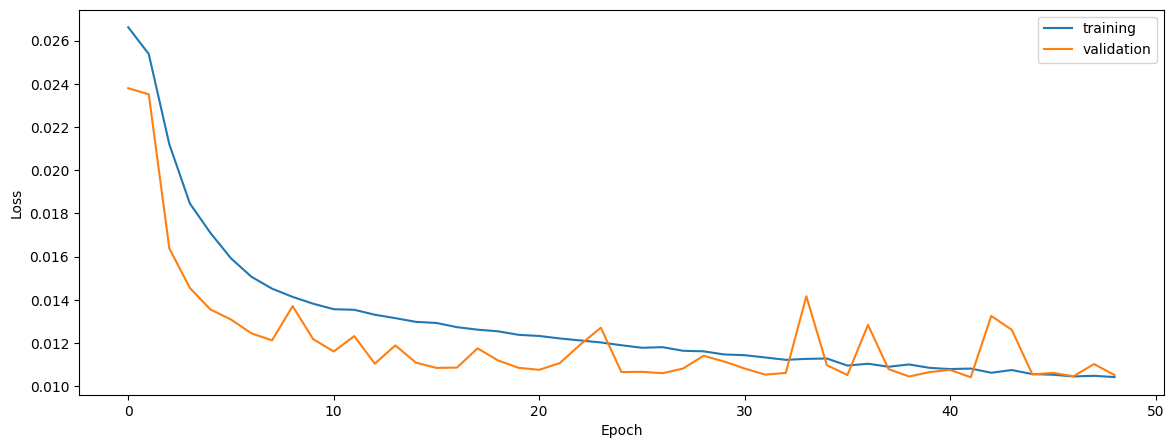

0.4596455797820994
0.42874399851830325
0.519862255285352


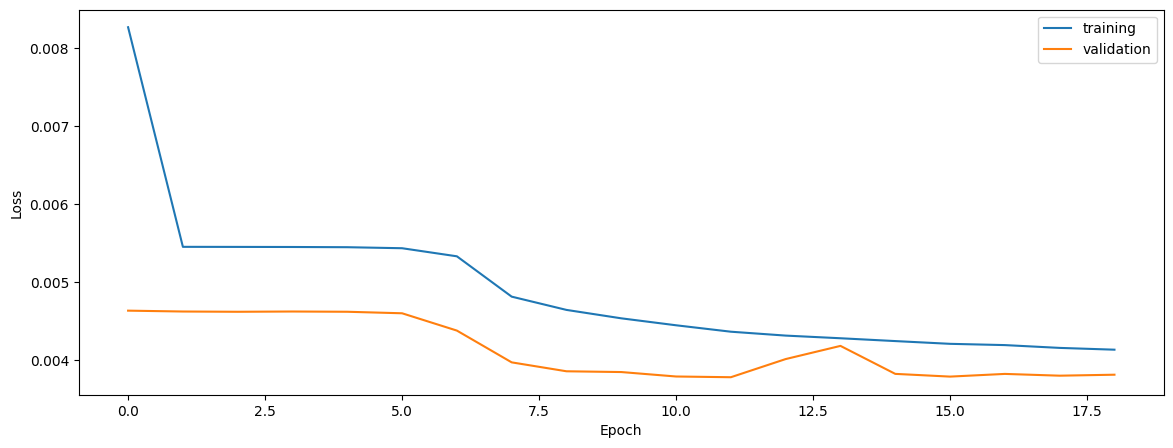

0.6289966696830323
0.5788670985292155
0.6436997813158144


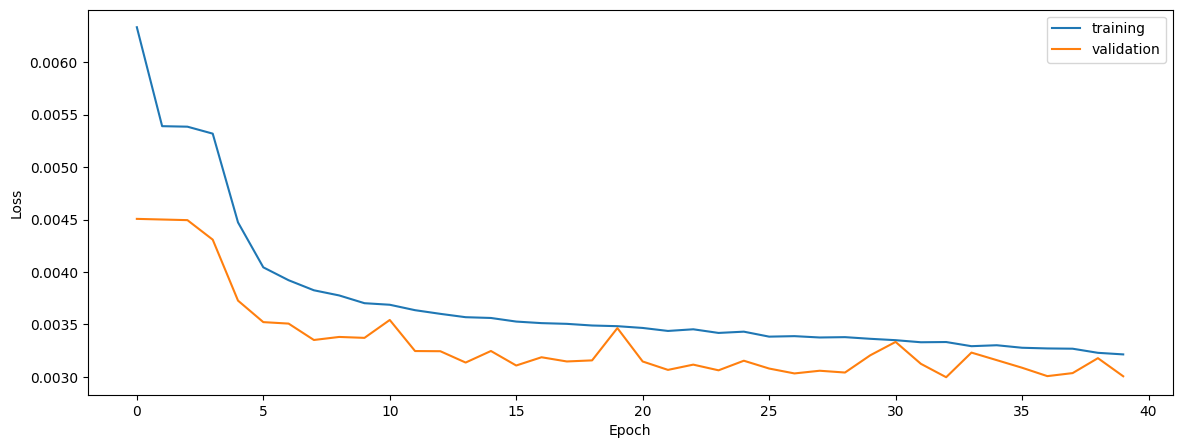

0.6955299587630696
0.637491631535666
0.586045293384929


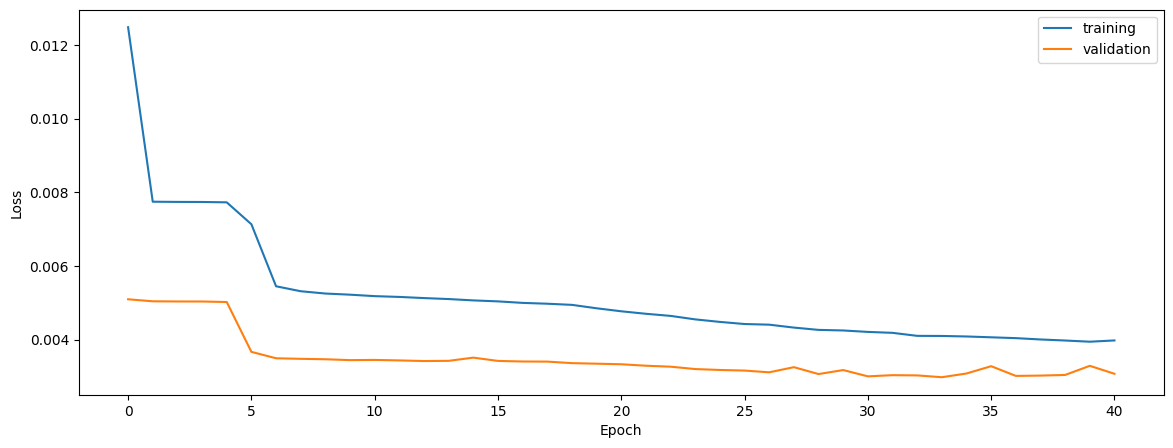

0.7363738526299282
0.592399422999565
0.6791200927744027


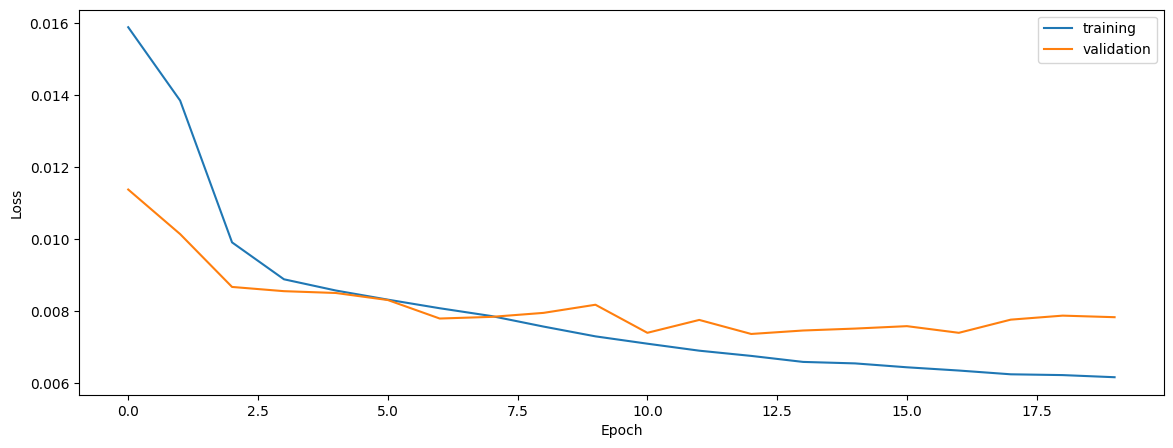

0.5065658854266233
0.427182464591191
0.4253877021135688


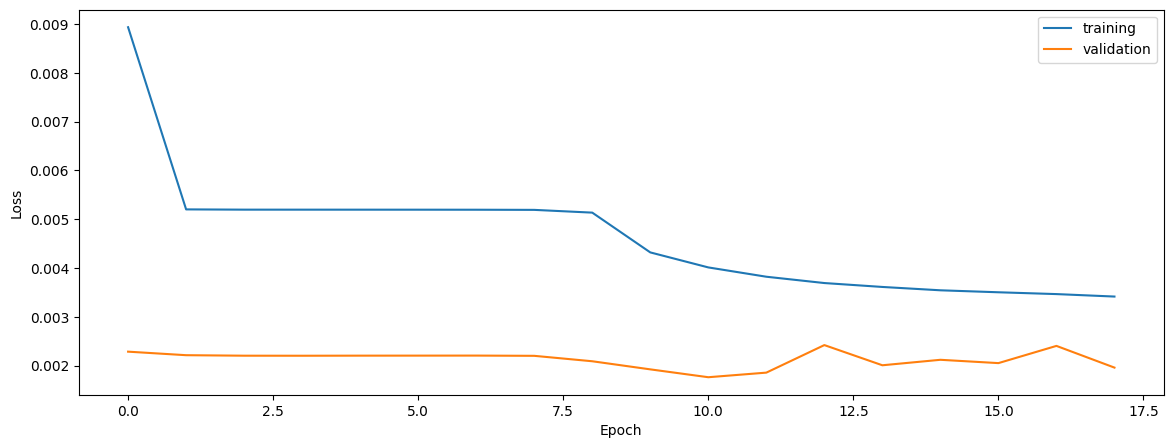

0.5174825559731205
0.45885617097316417
0.5121923715257227


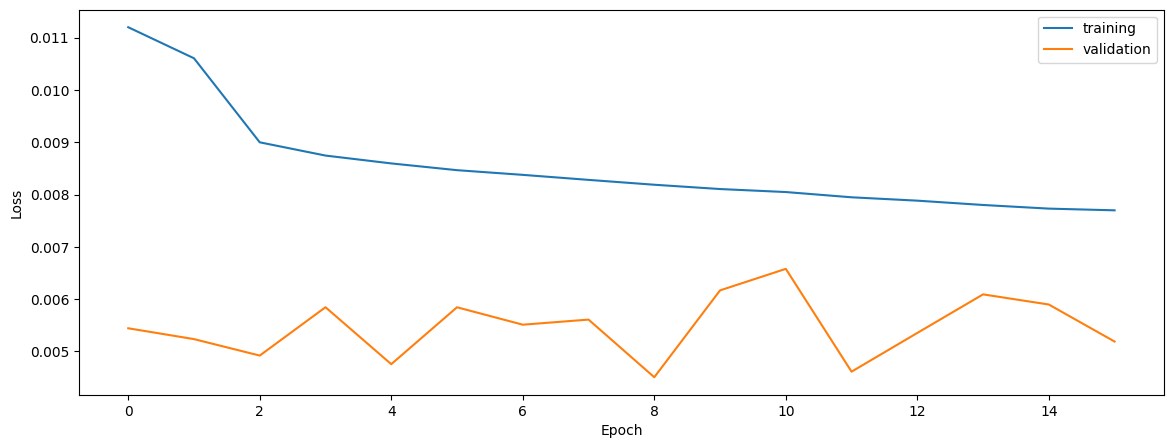

In [3]:
from DataGenerator import DataGenerator
import os
from util import pickleSave
from Model import *
from tensorflow.keras.optimizers import Adam
from util import pickleLoad
from visual import plotHistory
from util import predictInBatches, getPearson
import numpy as np
import keras

path = props['path']+'/models'

train_true = []
val_true = []
test_true = []
train_pred = []
val_pred = []
test_pred = []
train_warp = None
val_warp = None
test_warp = None
train_splits = None
val_splits = None
test_splits = None

class CustomEarlyStopping(keras.callbacks.Callback):
    def __init__(self, monitor='loss', patience=0):
        super().__init__()
        self.monitor = monitor
        self.patience = patience
    def on_train_begin(self, logs=None):
        self.wait = 0
        self.best = np.inf
        self.minSTDreached = False
    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if logs.get('STD') > 0.001:
            self.minSTDreached = True
        if current < self.best:
            self.wait = 0
            self.best = current
        elif not self.minSTDreached:
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.stop_training = True

for i in range(7):
    props['single'] = i
    HASHID, HASH = getHashId(architecture,props)

    gen = DataGenerator(**props)
    train, val, test = gen.getData()

    stop = CustomEarlyStopping(
        monitor='val_loss',
        patience=architecture['patience'],
    )
    save = tf.keras.callbacks.ModelCheckpoint(
        filepath=path+'/{}.weights.h5'.format(HASHID),
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_weights_only=True,
    )

    model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

    model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

    if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
        history = model.fit(DataWrapper(train,architecture['batch_size']),
            validation_data=DataWrapper(val,architecture['batch_size'],False),
            epochs=10000,
            verbose=0,
            callbacks = [save,stop],
        )
        pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

    model.load_weights(path+'/{}.weights.h5'.format(HASHID))

    train_true.append(train[1])
    val_true.append(val[1])
    test_true.append(test[1])
    train_pred.append(predictInBatches(model,train[0],architecture['batch_size']))
    val_pred.append(predictInBatches(model,val[0],architecture['batch_size']))
    test_pred.append(predictInBatches(model,test[0],architecture['batch_size']))
    print(getPearson(train_true[-1],train_pred[-1]))
    print(getPearson(val_true[-1],val_pred[-1]))
    print(getPearson(test_true[-1],test_pred[-1]))
    train_warp = train[2]
    val_warp = val[2]
    test_warp = test[2]
    train_splits = train[3]
    val_splits = val[3]
    test_splits = test[3]

    history = pickleLoad(path+'/{}.pkl'.format(HASHID))
    plotHistory(history)

def ste2con(ste):
    ste2 = np.repeat(np.expand_dims(np.sum(ste,-1),-1),ste.shape[-1],-1)
    ste2 = np.where(ste2==0,1,ste2)
    ste2 = ste/ste2
    return ste2

def addNotConnected(con):
    con = np.where(con <= threshold, 0, con)
    nc = (np.sum(con, axis=-1)*-1)+1
    nc = np.expand_dims(nc, -1)
    con = np.concatenate([con,nc],-1)
    return con

train_true = addNotConnected(ste2con(np.concatenate(train_true,-1)))
val_true = addNotConnected(ste2con(np.concatenate(val_true,-1)))
test_true = addNotConnected(ste2con(np.concatenate(test_true,-1)))
train_pred = addNotConnected(ste2con(np.concatenate(train_pred,-1)))
val_pred = addNotConnected(ste2con(np.concatenate(val_pred,-1)))
test_pred = addNotConnected(ste2con(np.concatenate(test_pred,-1)))

In [4]:
from util import getAccuracy

print('train')
print(getAccuracy(train_true,train_pred))
print(getAccuracy(val_true,val_pred))
print(getAccuracy(test_true,test_pred))

train
0.6507053267185218
0.6531091972187105
0.6400473262681012


In [5]:
print(props['space'])
print(getAccuracy(train_true,train_pred,train_splits[0]))
print(getAccuracy(val_true,val_pred,val_splits[0]))
print(getAccuracy(test_true,test_pred,test_splits[0]))

normalized
0.6511770741579445
0.6526012512654916
0.6380775749464301


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train_true[train_warp],train_pred[train_warp],train_splits[1]))
print(getAccuracy(val_true[val_warp],val_pred[val_warp],val_splits[1]))
print(getAccuracy(test_true[test_warp],test_pred[test_warp],test_splits[1]))

native
0.6533898584052434
0.655984203218327
0.6386142482087013


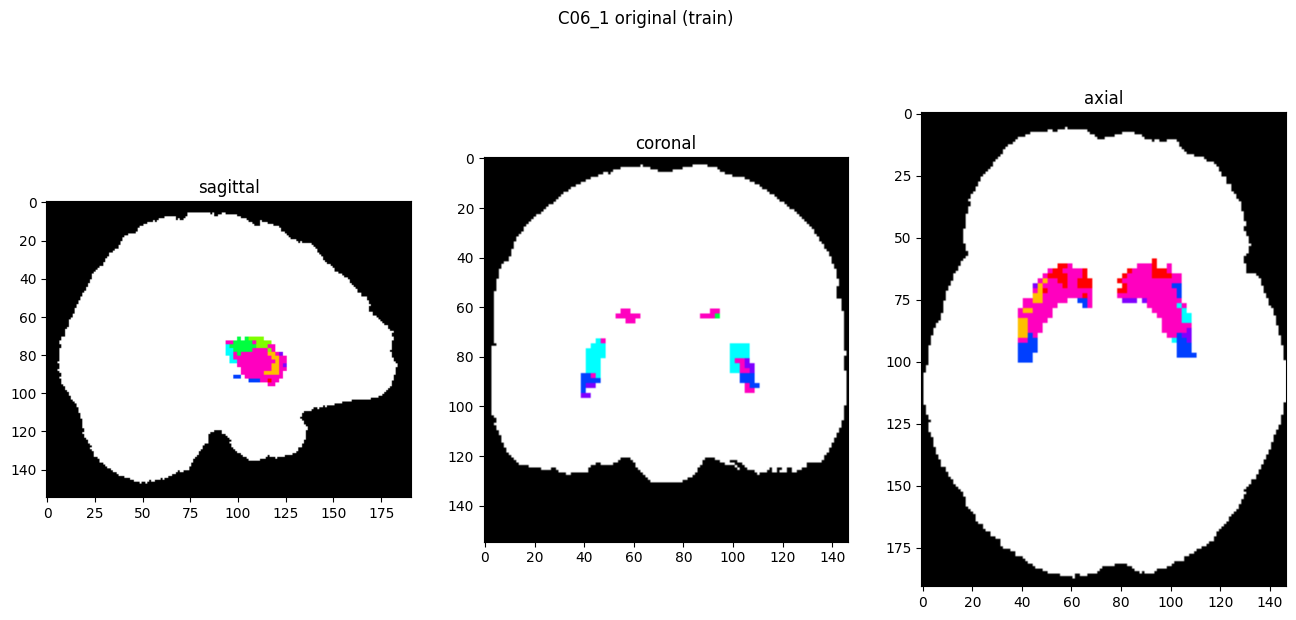

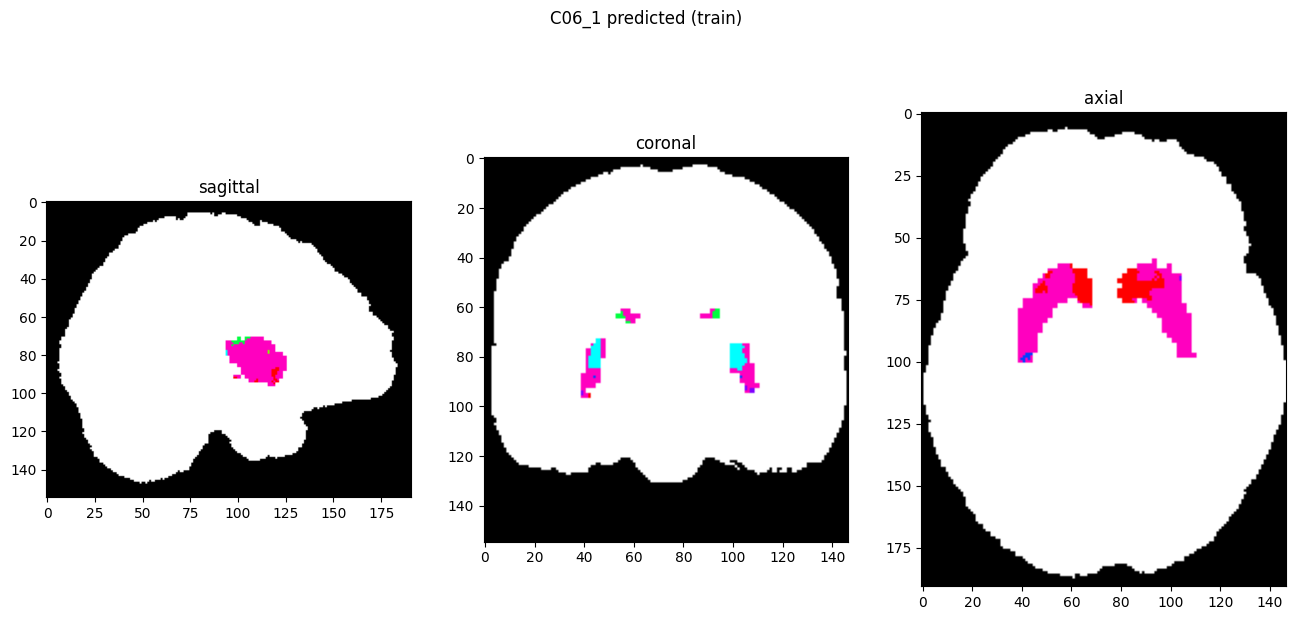

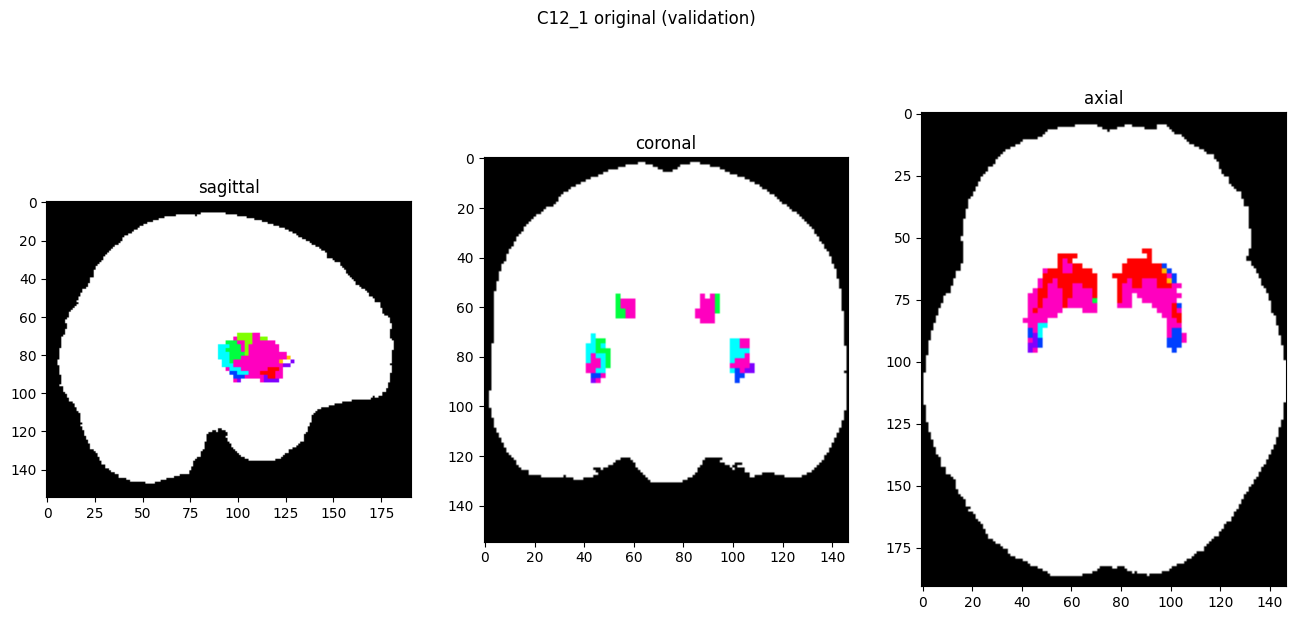

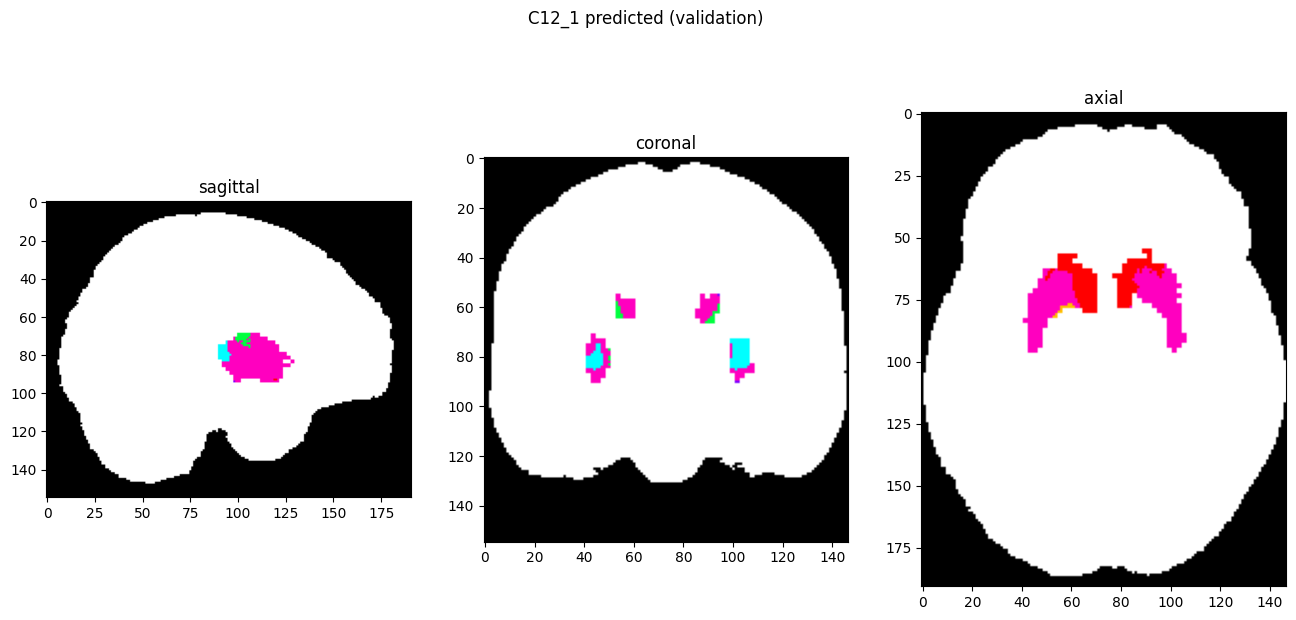

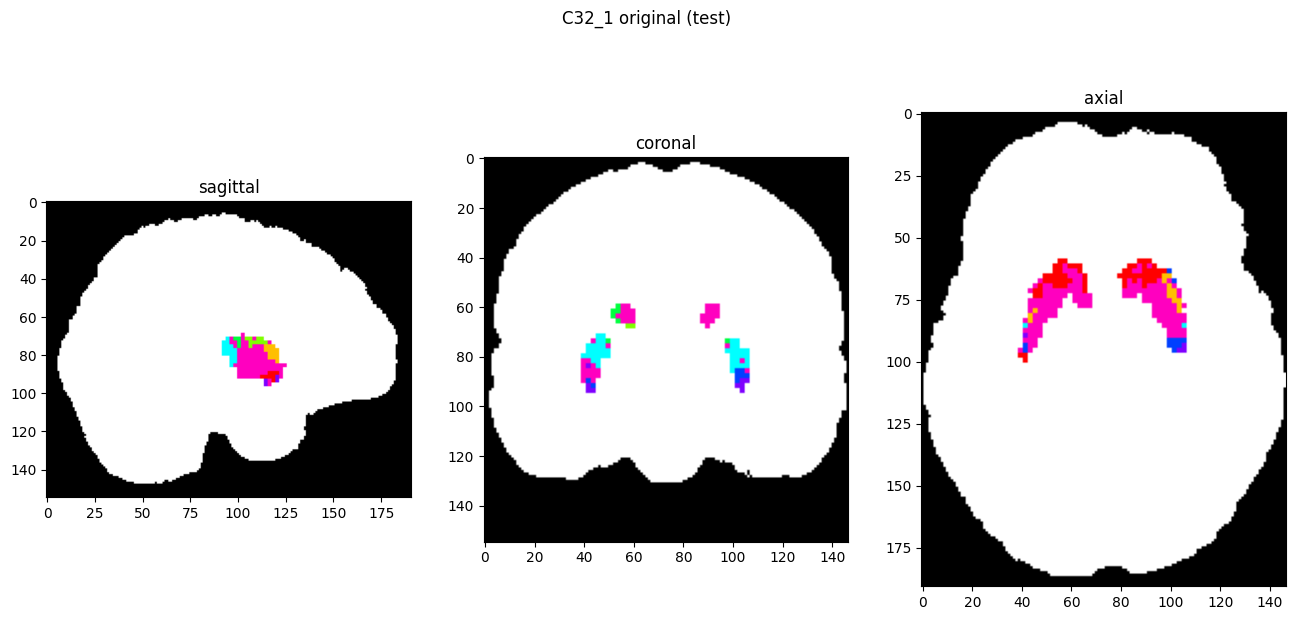

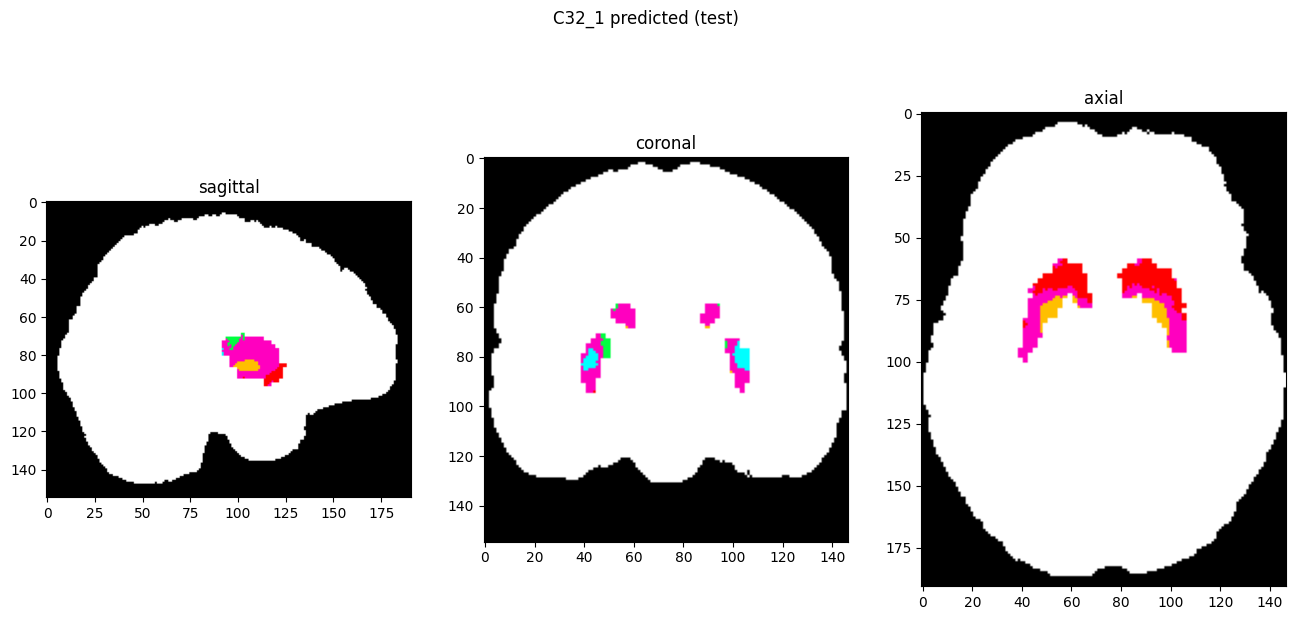

In [7]:
def y_pred(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    data_len = [train_splits,val_splits,test_splits][idx][0][1]
    return [train_pred,val_pred,test_pred][idx][0:data_len]
def y_true(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    data_len = [train_splits,val_splits,test_splits][idx][0][1]
    return [train_true,val_true,test_true][idx][0:data_len]

showResults(model, gen, threshold=0, predict=y_pred, label_true=y_true)

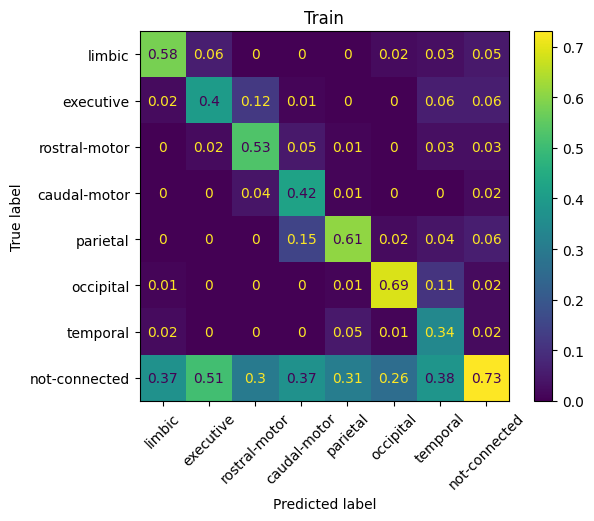

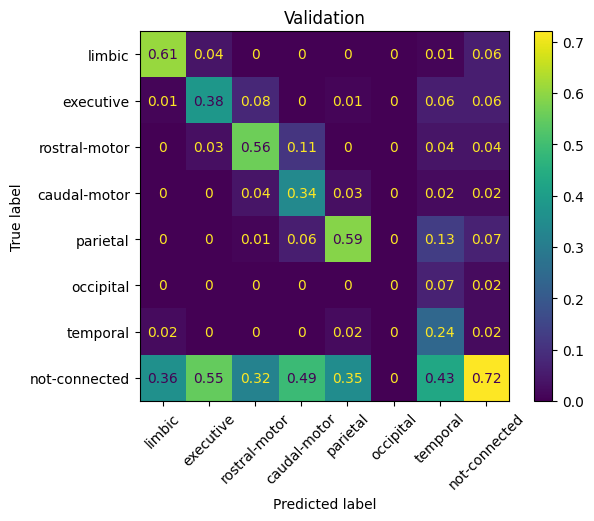

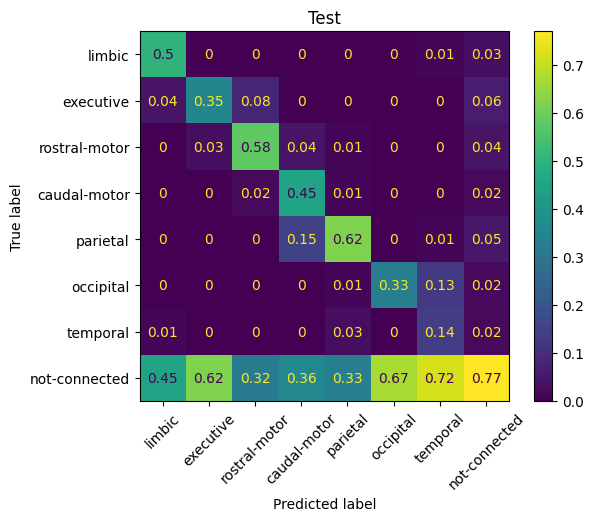

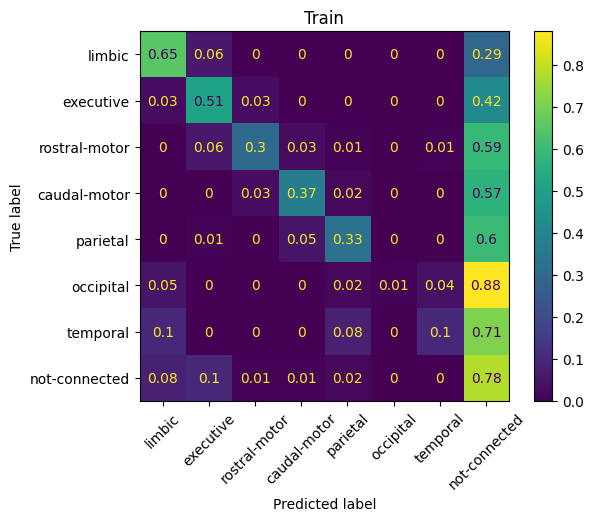

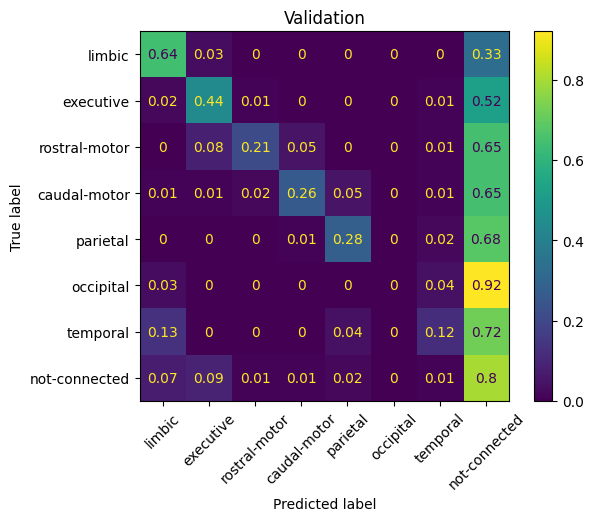

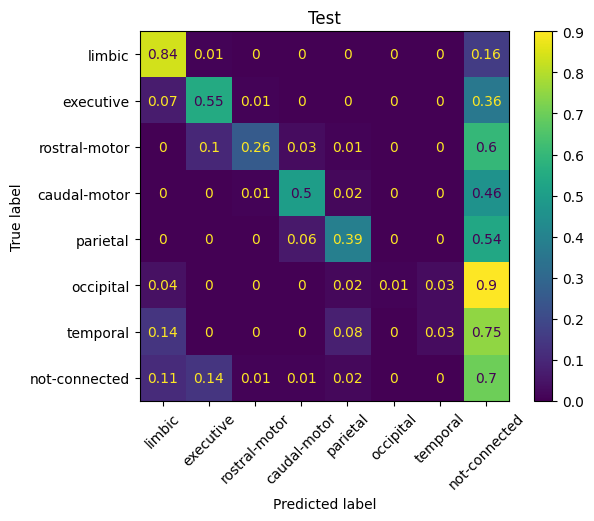

In [8]:
from visual import plotConfusionMatrix

labels = np.concatenate([np.load('data/preprocessed/labels.npy'),['not-connected']])

plotConfusionMatrix(train_true,train_pred,labels,'Train')
plotConfusionMatrix(val_true,val_pred,labels,'Validation')
plotConfusionMatrix(test_true,test_pred,labels,'Test')

plotConfusionMatrix(train_true,train_pred,labels,'Train',norm='true')
plotConfusionMatrix(val_true,val_pred,labels,'Validation',norm='true')
plotConfusionMatrix(test_true,test_pred,labels,'Test',norm='true')